# OMG: ACT CMB TSZ PDF LFI
Start with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import h5py
import ndes.ndes as ndes
import scipy.interpolate as si
import delfi.delfi as delfi
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

Now define some functions: need derivatives of data with respect to parameters (versions for theoretical mean and using simulations), Fisher matrix and a simulation compressor. Specifically, for the compression we're assuming the data are drawn from a multinomial distribution, so we need 1) the data to be histograms and 2) the derivatives to be of PDFs.

In [2]:
# functions
def fisher_matrix(n_pix, pdf_fid, dpdpar):

    n_pix_f = float(n_pix)
    n_bins, n_pars = dpdpar.shape
    f_mat = np.zeros((n_pars, n_pars))
    for i in range(n_pars):

        for j in range(i + 1):

            for k in range(n_bins):

                f_mat[i, j] += (1.0 / pdf_fid[k] - 1.0 + n_pix_f) * \
                               dpdpar[k, i] * dpdpar[k, j]
                others = np.array([False if m == k else \
                                   True for m in range(n_bins)])
                f_mat[i, j] += np.sum((n_pix_f - 1.0) * \
                                      dpdpar[k, i] * \
                                      dpdpar[others, j])
            f_mat[j, i] = f_mat[i, j]
    f_mat *= n_pix_f
    
    return f_mat

# compressor function must have the form 
# compressor(data, args) -> compressed summaries (pseudo-MLE)
def compressor(data, args):
    
    # compress using score
    pars_fid, pdf_fid, dpdpar, f_inv = args
    d_comp = np.dot(data / pdf_fid, dpdpar)
    return pars_fid + np.dot(f_inv, d_comp)

Basic setup.

In [3]:
# fiducial cosmology
a_s_fid = 2.71826876e-09
sig_8_fid = 0.7999741174575746
om_m_fid = 0.25
p_0_fid = 1.0
sig_n_fid = 1.0
delta = 0.1
pars_fid = np.array([sig_8_fid, om_m_fid, p_0_fid, sig_n_fid])
dpar = 2.0 * delta * pars_fid
labels = [r'$\sigma_8$', r'$\Omega_m$', r'$P_0$', r'$\sigma_{\rm noise}$']
labels_raw = [label.replace('$', '') for label in labels]

# temperature bins
temp_min = -120.0
temp_max = 0.0
temp_step = 10.
temp_bin_edges = np.arange(temp_min, temp_max, temp_step)
temp_bins = np.arange(temp_min + temp_step / 2.0, temp_max - temp_step / 2.0, temp_step)

Read in simulations. The simulations are on a Latin hypercube of $\sigma_8$, $\Omega_m$, $P_0$ and $T_0$ values. Currently we have 1000 in total, each a histogram summing to one.

In [4]:
# read simulated data
data_dir = '/Users/sfeeney/Software_Packages/leander_tsz/outputs/'
par_grid = np.genfromtxt(data_dir + 'tszpdflfi/par_grid.txt')
n_sims = par_grid.shape[0]
n_bins = 11
pdfs = np.zeros((n_sims, n_bins))
for i in range(n_sims):
    pdf = np.genfromtxt(data_dir + 'tszpdflfi/combined_hist_{:d}.txt'.format(i))[0: n_bins]
    pdfs[i, :] = pdf / np.sum(pdf)

In [5]:
# calculate typical number of pixels in histogram
n_pix = 441685 # @TODO: check this is correct!

Pick out data realization, define fiducial parameter constraints, calculate derivatives and Fisher.

In [6]:
dists = np.zeros(n_sims)
for i in range(n_sims):
    dists[i] = np.sqrt((par_grid[i, 0] - sig_8_fid) ** 2 + \
                       (par_grid[i, 1] - om_m_fid) ** 2 + \
                       (par_grid[i, 2] - p_0_fid) ** 2 + \
                       (par_grid[i, 3] - sig_n_fid) ** 2)
i_data = np.argmin(dists)
pdf_data = pdfs[i_data, :]

In [7]:
# read in fiducial PDF, interpolate and normalize as required
pdf_fid = np.genfromtxt(data_dir + 'fiducial_pdf_hi_res_alt_wf.txt')
pdf_fid_interp = si.interp1d(pdf_fid[:, 0], pdf_fid[:, 1])
pdf_fid = pdf_fid_interp(temp_bins)
pdf_fid /= np.sum(pdf_fid)

Text(0,0.5,'$\\partial p/\\partial \\theta$')

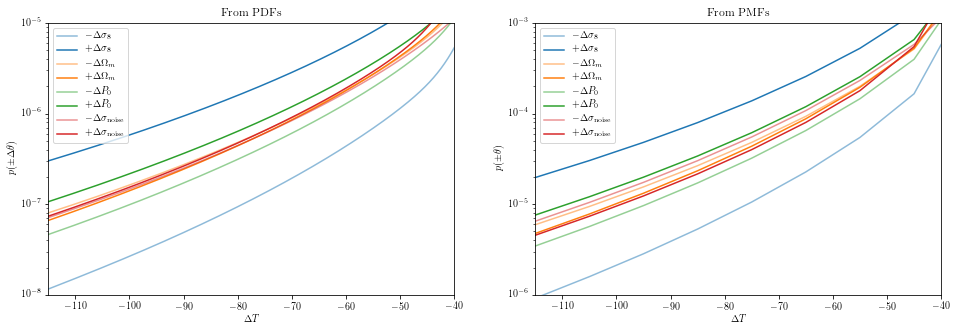

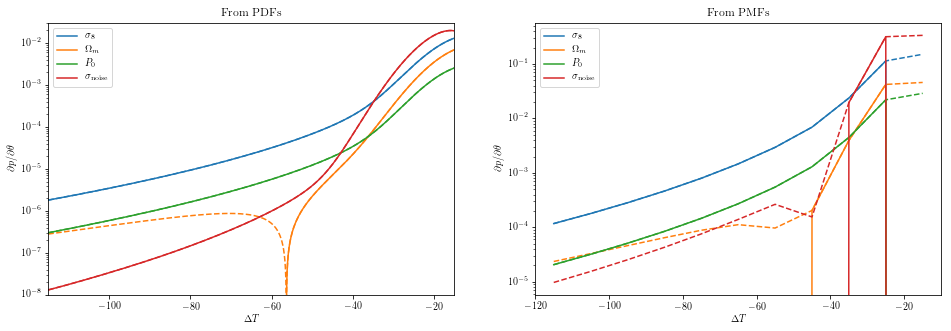

In [8]:
# calculate derivatives from analytic PDFs. PDFs are generated over 
# finer and broader grid than needed. Interpolate onto correct grid 
# and normalize to sum to 1, as required by assumption of multinomial 
# likelihood 
deriv_pdfs = np.genfromtxt(data_dir + 'derivatives_components_hi_res_alt_wf.txt').T
fig_p, axes_p = plt.subplots(1, 2, figsize=(16, 5))
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
dpdpar = np.zeros((n_bins, 4))
for i in range(4):
    
    # normalize PDFs to sum to one over desired range and calculate derivatives
    ii = 2 * i + 1
    interp_minus = si.interp1d(deriv_pdfs[:, 0], deriv_pdfs[:, ii])
    interp_plus = si.interp1d(deriv_pdfs[:, 0], deriv_pdfs[:, ii + 1])
    pdf_minus = interp_minus(temp_bins)
    pdf_plus = interp_plus(temp_bins)
    pdf_minus /= np.sum(pdf_minus)
    pdf_plus /= np.sum(pdf_plus)
    dpdpar[:, i] = (pdf_plus - pdf_minus) / dpar[i]
    
    # plot constituent PDFs, PMFs and resulting derivatives
    axes_p[0].semilogy(deriv_pdfs[:, 0], deriv_pdfs[:, ii], color='C{:d}'.format(i), \
                       alpha=0.5, label=r'$-\Delta$'+labels[i])
    axes_p[0].semilogy(deriv_pdfs[:, 0], deriv_pdfs[:, ii + 1], color='C{:d}'.format(i), \
                       label=r'$+\Delta$'+labels[i])
    axes_p[1].semilogy(temp_bins, pdf_minus, color='C{:d}'.format(i), alpha=0.5, \
                       label=r'$-\Delta$'+labels[i])
    axes_p[1].semilogy(temp_bins, pdf_plus, color='C{:d}'.format(i), \
                       label=r'$+\Delta$'+labels[i])
    axes[1].semilogy(temp_bins, dpdpar[:, i], color='C{:d}'.format(i), label=labels[i])
    axes[1].semilogy(temp_bins, np.abs(dpdpar[:, i]), color='C{:d}'.format(i), ls='--')
    
# finish plots
axes_p[0].set_xlim(temp_bins[0], -40.0)
axes_p[0].set_ylim(1.0e-8, 1.0e-5)
axes_p[0].legend(loc='upper left')
axes_p[0].set_title('From PDFs')
axes_p[0].set_xlabel(r'$\Delta T$')
axes_p[0].set_ylabel(r'$p(\pm\Delta\theta)$')
axes_p[1].set_xlim(temp_bins[0], -40.0)
axes_p[1].set_ylim(1.0e-6, 1.0e-3)
axes_p[1].legend(loc='upper left')
axes_p[1].set_title('From PMFs')
axes_p[1].set_xlabel(r'$\Delta T$')
axes_p[1].set_ylabel(r'$p(\pm\theta)$')
axes[1].legend(loc='upper left')
axes[1].set_title('From PMFs')
axes[1].set_xlabel(r'$\Delta T$')
axes[1].set_ylabel(r'$\partial p/\partial \theta$')

# also plot derivatives calculated using full PDFs
derivs = np.genfromtxt(data_dir + 'derivatives_hi_res_alt_wf.txt')
for i in range(4):
    axes[0].semilogy(derivs[:, 0], derivs[:, i + 1], color='C{:d}'.format(i), label=labels[i])
    axes[0].semilogy(derivs[:, 0], np.abs(derivs[:, i + 1]), color='C{:d}'.format(i), ls='--')
axes[0].set_xlim(temp_bins[0], temp_bins[-1])
axes[0].set_ylim(1.0e-8, 3.0e-2)
axes[0].legend(loc='upper left')
axes[0].set_title('From PDFs')
axes[0].set_xlabel(r'$\Delta T$')
axes[0].set_ylabel(r'$\partial p/\partial \theta$')

In [9]:
# Calculate Fisher matrix
f_mat = fisher_matrix(n_pix, pdf_fid, dpdpar)
f_mat_inv = np.linalg.inv(f_mat)
print('Fisher matrix constraints and correlation coefficients:')
for i in range(4):
    to_print = ''
    for j in range(i):
        rho = f_mat_inv[i, j] / np.sqrt(f_mat_inv[i, i] * f_mat_inv[j, j])
        to_print += '{: 5.3f} '.format(rho)
    print(to_print + '{: 5.3f}'.format(np.sqrt(f_mat_inv[i, i])))

Fisher matrix constraints and correlation coefficients:
 0.513
 0.851  0.080
-1.000 -0.851  2.757
-0.344 -0.764  0.343  0.006


Now, compress all of the simulations that we have using multinomial score compression. Check that the compressed sims look like ML draws from the Fisher matrix.

In [19]:
# Compress all sims

# NOTE: The compressed summaries should be in the form of pseudo maximum-likelihood parameter estimators
# ie, if you are using the score of an approximate log-likelihood L, you should use compressed summaries
# t = \theta_\mathrm{fiducial} + F^{-1}\nabla L where F is the approximate Fisher matrix
sims_comp = np.zeros((n_sims, 4))
args = [pars_fid, pdf_fid, dpdpar, f_mat_inv]
for i in range(n_sims):
    sims_comp[i, :] = compressor(pdfs[i, :] * n_pix, args)
data_comp = compressor(pdf_data * n_pix, args)
'''
m_to_p = np.mean(sims_comp[i_fid * n_sims: (i_fid + 1) * n_sims])
s_to_p = np.std(sims_comp[i_fid * n_sims: (i_fid + 1) * n_sims])
print('sigma_8: mean of simulations {:5.3f}; fiducial {:5.3f}'.format(m_to_p, sig_8_fid))
print('sigma_8: std of simulations {:5.3f}; sqrt(diag(F_inv)) {:5.3f}'.format(s_to_p, np.sqrt(f_mat_inv_ana)[0, 0]))
'''

"\nm_to_p = np.mean(sims_comp[i_fid * n_sims: (i_fid + 1) * n_sims])\ns_to_p = np.std(sims_comp[i_fid * n_sims: (i_fid + 1) * n_sims])\nprint('sigma_8: mean of simulations {:5.3f}; fiducial {:5.3f}'.format(m_to_p, sig_8_fid))\nprint('sigma_8: std of simulations {:5.3f}; sqrt(diag(F_inv)) {:5.3f}'.format(s_to_p, np.sqrt(f_mat_inv_ana)[0, 0]))\n"

Set up priors...

In [20]:
# Set up the truncated Gaussian prior...

# Prior parameter boundaries
lower = np.min(par_grid, axis=0)
upper = np.max(par_grid, axis=0)

# Prior mean and covariance
prior_mean = np.array([0.8, 0.25, 1.0, 1.0])
prior_cov = np.diag(np.array([1.0, 1.0, 0.1, 0.1])**2)

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, prior_cov, lower, upper)

In [21]:
# Update Fisher matrix prediction to use priors
f_mat_plus_prior = f_mat + np.linalg.inv(prior_cov)
fmpp_inv = np.linalg.inv(f_mat_plus_prior)
print('Fisher matrix constraints and correlation coefficients, including priors:')
for i in range(4):
    to_print = ''
    for j in range(i):
        rho = fmpp_inv[i, j] / np.sqrt(fmpp_inv[i, i] * fmpp_inv[j, j])
        to_print += '{: 5.3f} '.format(rho)
    print(to_print + '{: 5.3f}'.format(np.sqrt(fmpp_inv[i, i])))

Fisher matrix constraints and correlation coefficients, including priors:
 0.019
 0.042  0.042
-0.988 -0.059  0.100
-0.028 -0.956  0.013  0.006


Set up the DELFI object (using a single MAF thang ATM) and load in simulations on grid.

In [22]:
# Set up the Delfi object...

# Create the neural density estimator (MAF stands for Masked Autoregressive Flow)
# NOTE: n_inputs = number of parameters, n_outputs = number of compressed summaries
#NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=4, n_data=4, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0)]

# Create the DELFI object
DelfiNDE = delfi.Delfi(data_comp, prior, NDEs, Finv=f_mat_inv, theta_fiducial=pars_fid, 
                       param_limits = [lower, upper], param_names = labels_raw, 
                       results_dir = "simulators/tsz_pdf/results_prerun_t18/",
                       input_normalization="fisher")

# Load in the simulations
DelfiNDE.load_simulations(sims_comp, par_grid)

Fisher pretraining: initialize MAF by fitting to draws from boosted Fisher matrix.

In [23]:
# Do the Fisher pre-training step to initialize the network
DelfiNDE.fisher_pretraining()

DELFI training.

In [24]:
# Train the network
DelfiNDE.train_ndes(training_data=[DelfiNDE.x_train, DelfiNDE.y_train], epochs=500, patience=20, batch_size=100)

Got the posterior now, so draw some samples from it so we can plot the world's most underwhelming posterior!

In [25]:
# MCMC sample the learned posterior
posterior_samples = DelfiNDE.emcee_sample(DelfiNDE.log_posterior_stacked, [DelfiNDE.posterior_samples[-i,:] for i in range(DelfiNDE.nwalkers)], burn_in_chain=100, main_chain=1000)

/Users/sfeeney/Software_Packages/delfi/delfi/delfi.py:184: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Removed no burn in


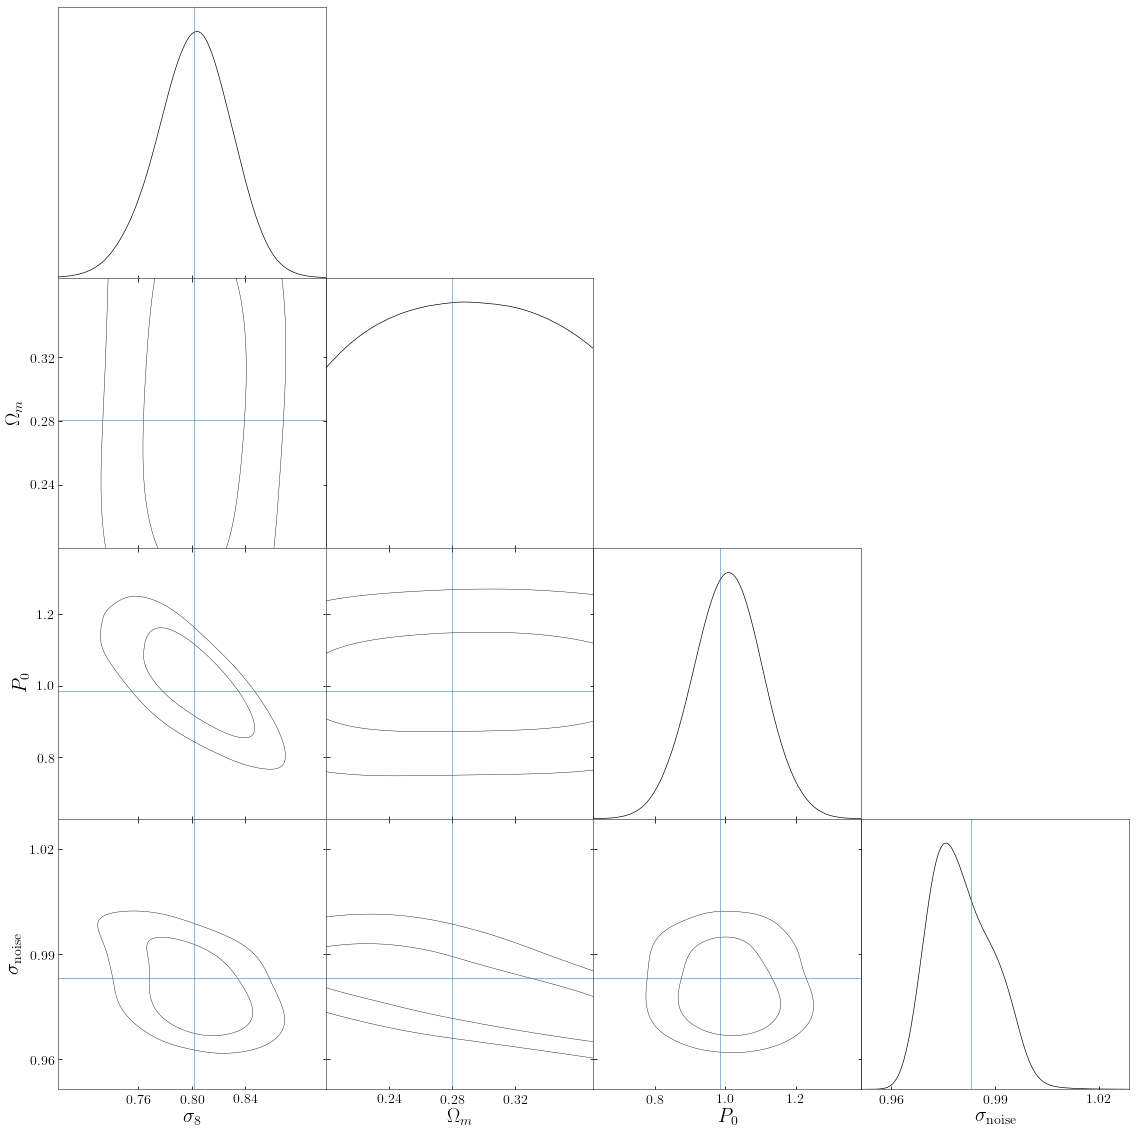

In [62]:
# Let's plot the recovered posterior
'''
plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})'''

# create GetDist mc_samples object(s)
names = ['s8', 'omm', 'p0', 'sn']
labels = labels_raw
ranges = dict(zip(names, [ [lower[i], upper[i]] for i in range(len(names)) ]))
samples = [posterior_samples]
mc_samples = [MCSamples(samples=s, names = names, labels = labels, ranges = ranges) for s in samples]

# plot parameter constraints
g = plots.getSubplotPlotter(width_inch = 16)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20
g.triangle_plot(mc_samples, normalized=True)
for i in range(0, 4):
    for j in range(0, i + 1):
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(par_grid[i_data, i])
        else:
            ax.axhline(par_grid[i_data, i])
            ax.axvline(par_grid[i_data, j])

In [63]:
# Report constraints
for mcs in mc_samples:
    stats = mcs.getMargeStats()
    for i in range(4):
        print(names[i])
        print('input:', par_grid[i_data, i], '+/-', np.sqrt(fmpp_inv)[i, i])
        print('infer:', stats.parWithName(names[i]).mean, '+/-', stats.parWithName(names[i]).err)

s8
input: 0.8014011629812282 +/- 0.01881348082584622
infer: 0.8014220268135771 +/- 0.027878508570106136
omm
input: 0.2804417718439079 +/- 0.041757402340183644
infer: 0.28592426162450796 +/- 0.047198012758888123
p0
input: 0.9840340604681594 +/- 0.09991667040187908
infer: 1.0079307276250655 +/- 0.09850450162582848
sn
input: 0.9831567688656625 +/- 0.005922208424702105
infer: 0.9803911880265432 +/- 0.009017581688302993


/Users/sfeeney/Software_Packages/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [64]:
# Constraint on S_8
for mcs in mc_samples:
    samples = mcs.getParams()
    mcs.addDerived(samples.s8 * (samples.omm / 0.282) ** 0.2, \
                   name='S8omm', label=r'\Sigma_8')
    mcs.updateBaseStatistics()
    stats = mcs.getMargeStats()
    print('Sigma_8')
    print('input:', par_grid[i_data, 0] * (par_grid[i_data, 1] / 0.282) ** 2)
    print('infer:', stats.parWithName('S8omm').mean, '+/-', stats.parWithName('S8omm').err)

Sigma_8
input: 0.792569136411412
infer: 0.8018984711492539 +/- 0.03984446868555023


Text(0,0.5,'$P(\\Sigma_8|{\\rm data})$')

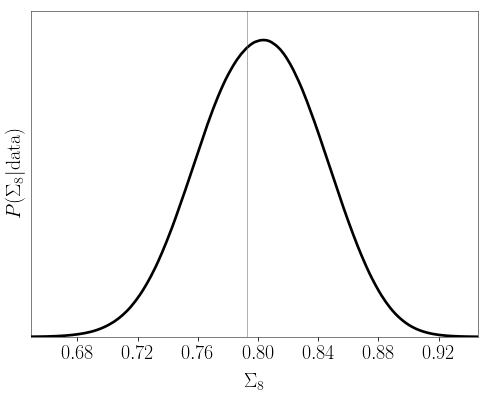

In [71]:
# Plot and report constraints
g = plots.getSinglePlotter(width_inch=8)
g.plot_1d(mc_samples, 'S8omm')
ax = plt.gca()
ax.axvline(par_grid[i_data, 0] * (par_grid[i_data, 1] / 0.282) ** 2)
ax.set_xlabel(r'$\Sigma_8$', fontsize=20)
ax.set_ylabel(r'$P(\Sigma_8|{\rm data})$', fontsize=20)